# Patentamens

Notebook para cálculo de estadisticas del juego de las patentes

## Setup

Leemos el archivo que contiene los datos `data.csv` para procesarlos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def read_data():
    # Read the data from the csv file
    data = pd.read_csv("data.csv")

    # convert the data to a dataframe
    df = pd.DataFrame(data)

    # convert fecha to datetime
    df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True)

    return df

df = read_data()


## Estadisticas Generales

### Número de patentes encontradas por persona

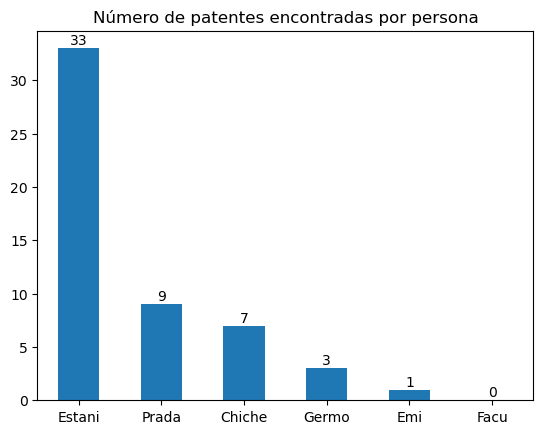

In [3]:
def plot_number_found(df: pd.DataFrame):
    # Plot the number of times each person found a patent ordered by the number of times they found a patent in descending order
    found_by = df.groupby("encontradaPor").size().sort_values(ascending=False)

    if "Facu" not in found_by:
        # Add Facu to the list of people :)
        found_by["Facu"] = 0

    found_by.plot(kind="bar")

    # Remove the x label
    plt.xlabel("")

    # Rotate the x labels
    plt.xticks(rotation=0)

    # Put the number of times found on top of the bars
    biggest = found_by.max()
    space_between = biggest * 0.01

    for i in range(len(found_by)):
        plt.text(
            i,
            found_by.values[i] + space_between,
            found_by.values[i],
            ha="center",
        )

    plt.title("Número de patentes encontradas por persona")
    plt.show()

plot_number_found(df.copy(deep=True))

### Patentes encontradas a lo largo del tiempo, marcando el mejor día

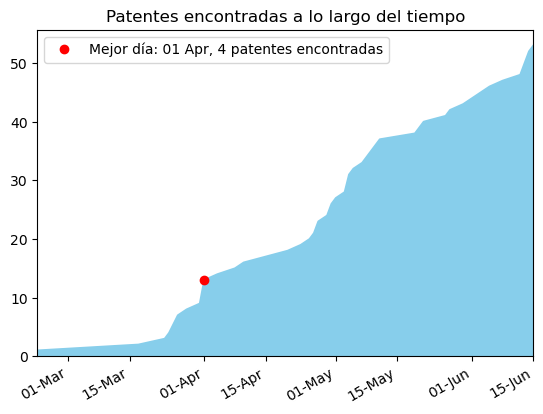

In [4]:
# Area chart
def plot_found_progress(df: pd.DataFrame):
    # Plot the number of patents found over time
    found_over_time = df.groupby("fecha").size().cumsum()

    found_over_time.plot(kind="area", color="skyblue")

    # Remove the x label
    plt.xlabel("")

    # Change the date format to show number of day and name of the month
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%d-%b"))

    # End the x axis at the last date
    plt.xlim(found_over_time.index[0], found_over_time.index[-1])

    # Get current x-ticks and add the last date if not already present
    xticks = plt.gca().get_xticks()
    last_date = found_over_time.index[-1]
    if plt.matplotlib.dates.date2num(last_date) not in xticks:
        # Remove the last x-tick and add the last date if the difference between the last two dates less than 10 days
        if (last_date - found_over_time.index[-2]).days < 10:
            xticks = xticks[:-1]
        xticks = list(xticks) + [plt.matplotlib.dates.date2num(last_date)]
        plt.gca().set_xticks(xticks)

    # Mark the best day in which the most patents were found with a red dot
    best_day = df.groupby("fecha").size().idxmax()
    best_day_formatted = best_day.strftime("%d %b")
    patents_found = df.groupby("fecha").size().max()
    height_best_day = found_over_time.loc[best_day]

    plt.plot_date(
        best_day,
        height_best_day,
        color="red",
        label=f"Mejor día: {best_day_formatted}, {patents_found} patentes encontradas",
    )

    plt.legend(loc="upper left")
    plt.title("Patentes encontradas a lo largo del tiempo")
    plt.show()

plot_found_progress(df.copy(deep=True))

### Distribución de patentes encontradas por momento del día

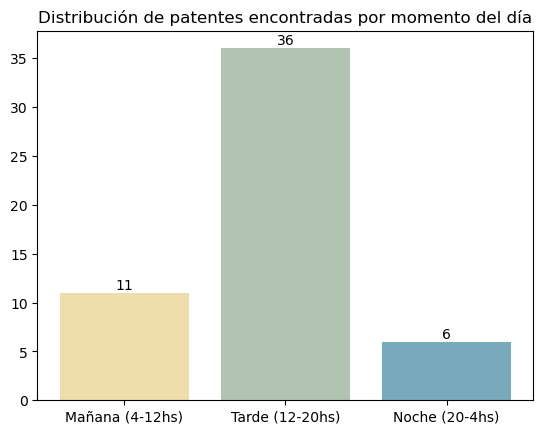

In [5]:
def plot_hour_distribution(df: pd.DataFrame):
    # Plot the distribution of the hour in which the patents were found
    found_at_hour = df.groupby(df["horaDelDia"]).size()

    # Add the missing hours
    for i in range(24):
        if i not in found_at_hour.index:
            found_at_hour[i] = 0

    found_at_hour = found_at_hour.sort_index()

    # Distribute in morning, afternoon and night
    morning = found_at_hour.loc[4:11].sum()
    afternoon = found_at_hour.loc[12:19].sum()
    night = found_at_hour.loc[20:23].sum() + found_at_hour.loc[0:3].sum()

    # Plot the distribution of the parts of the day with gradient colors
    plt.bar(
        ["Mañana (4-12hs)", "Tarde (12-20hs)", "Noche (20-4hs)"],
        [morning, afternoon, night],
        color=sns.color_palette("blend:#EDA,#7AB", 3),
    )

    # Put the number of patents found on top of the bars
    biggest = max(morning, afternoon, night)
    space_between = biggest * 0.01

    for i in range(3):
        plt.text(
            i,
            [morning, afternoon, night][i] + space_between,
            [morning, afternoon, night][i],
            ha="center",
        )

    plt.title("Distribución de patentes encontradas por momento del día")
    plt.show()


plot_hour_distribution(df.copy(deep=True))

### Distribuición de patentes encontradas por día de la semana

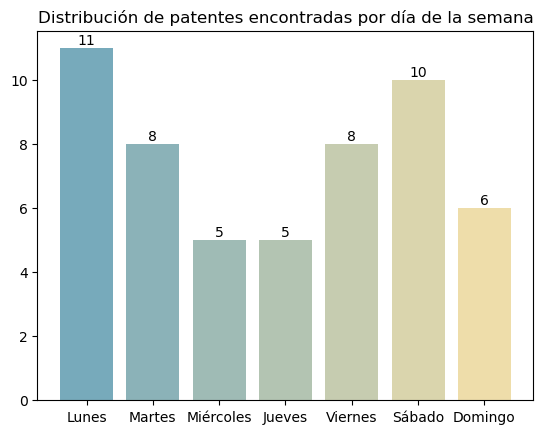

In [6]:
def plot_day_distribution(df: pd.DataFrame):
    # Plot the distribution of the day of the week in which the patents were found
    found_on_day = df.groupby(df["fecha"].dt.day_name()).size()

    day_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Sort the days of the week
    found_on_day = found_on_day.reindex(day_order)

    # Add the missing days
    for day in day_order:
        if day not in found_on_day.index:
            found_on_day[day] = 0

    # Transform the index to spanish
    found_on_day.index = [
        "Lunes",
        "Martes",
        "Miércoles",
        "Jueves",
        "Viernes",
        "Sábado",
        "Domingo",
    ]

    # Plot the distribution of the days of the week with gradient colors
    plt.bar(
        found_on_day.index,
        found_on_day,
        color=sns.color_palette("blend:#7AB,#EDA", 7),
    )

    # Put the number of patents found on top of the bars
    biggest = found_on_day.max()
    space_between = biggest * 0.01 # 1% of the biggest number

    for i in range(7):
        plt.text(
            i,
            found_on_day.values[i] + space_between,
            found_on_day.values[i],
            ha="center",
        )

    plt.title("Distribución de patentes encontradas por día de la semana")
    plt.show()

plot_day_distribution(df.copy(deep=True))

### Distribución de marcas de autos encontradas

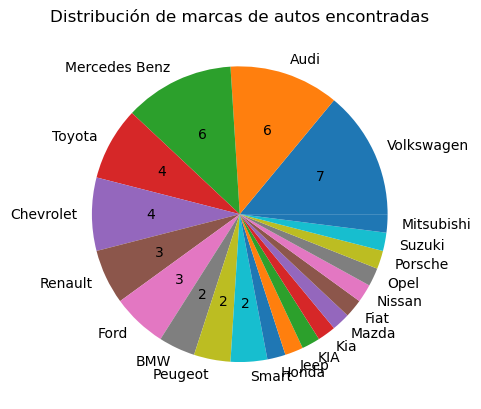

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


def car_brand_distribution(df: pd.DataFrame):
    # Plot the distribution of the car brands of the patents found
    car_brands = df.groupby("marca").size().sort_values(ascending=False)

    # Calculate the total number of items to use in the autopct function
    total = car_brands.sum()

    # Function to conditionally display the number
    def autopct(pct):
        absolute = round(pct / 100.0 * total)
        return str(absolute) if pct > 3 else ""

    # Plot the distribution of the car brands with gradient colors
    plt.pie(
        car_brands,
        labels=car_brands.index,
        autopct=autopct
    )

    plt.title("Distribución de marcas de autos encontradas")
    plt.show()


car_brand_distribution(df.copy(deep=True))

### Distribución de tipos de vehículos encontrados

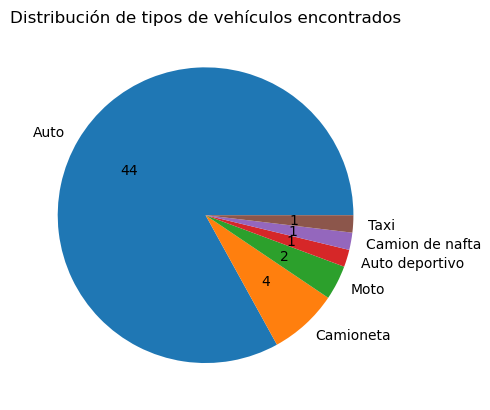

In [8]:
def car_type_distribution(df: pd.DataFrame):
    # Plot the distribution of the car types of the patents found
    car_types = df.groupby("vehiculo").size().sort_values(ascending=False)

    # Calculate the total number of items to use in the autopct function
    total = car_types.sum()

    # Function to conditionally display the number
    def autopct(pct):
        absolute = round(pct / 100.0 * total)
        return str(absolute) if pct > 0 else ""

    # Plot the distribution of the car types with gradient colors
    plt.pie(
        car_types,
        labels=car_types.index,
        autopct=autopct
    )

    plt.title("Distribución de tipos de vehículos encontrados")
    plt.show()

car_type_distribution(df.copy(deep=True))

## Estadisticas Copadas

### Mejor racha de patentes encontradas seguidas

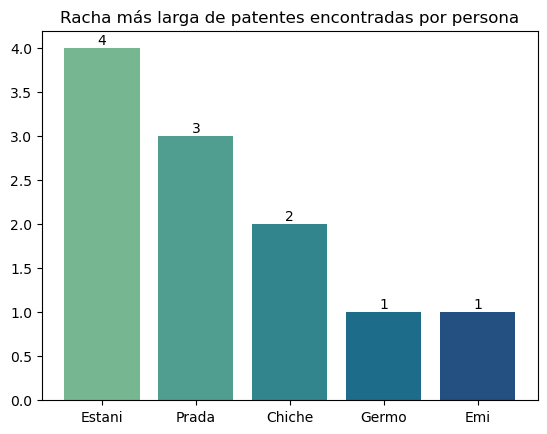

In [9]:
def find_longest_streak_for_each_participant(df: pd.DataFrame):
    all_participants = df["encontradaPor"].unique()

    longest_streak_by_participant = dict()

    for participant in all_participants:
        longest_streak = 0
        current_streak = 0
        for i in range(len(df)):
            if df["encontradaPor"].iloc[i] == participant:
                current_streak += 1
                if current_streak >= longest_streak:
                    longest_streak = current_streak
            else:
                current_streak = 0
        longest_streak_by_participant[participant] = longest_streak

    return longest_streak_by_participant

def plot_longest_streak():
    longest_streak_by_participant = find_longest_streak_for_each_participant(df)

    # Sort the participants by the length of their longest streak
    sorted_participants = sorted(
        longest_streak_by_participant.items(), key=lambda x: x[1], reverse=True
    )

    # Plot the longest streak of each participant
    plt.bar(
        [participant[0] for participant in sorted_participants],
        [participant[1] for participant in sorted_participants],
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the number of patents found on top of the bars
    biggest = sorted_participants[0][1]
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants[i][1] + space_between,
            sorted_participants[i][1],
            ha="center",
        )

    plt.title("Racha más larga de patentes encontradas por persona")
    plt.show()


plot_longest_streak()

### Patentes totales vistas por probabilidad

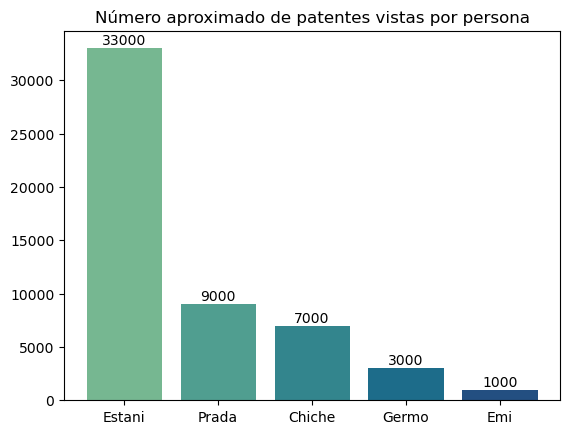

In [10]:
def plot_expected_total_patentes_seen_for_each_participant(df: pd.DataFrame):
    patentes_found_by_participant = df.groupby("encontradaPor").size()

    # If we asume that all patentes are equally likely to be found,
    # the probability of finding a patente is 1/1000
    probability = 1 / 1000

    # Calculate the expected number of patents found by each participant
    expected_patentes_found = patentes_found_by_participant * (1 / probability)

    # Convert the expected number of patents found to integers
    expected_patentes_found = expected_patentes_found.astype(int)

    # Sort the participants by the expected number of patents found
    sorted_participants = expected_patentes_found.sort_values(ascending=False)

    # Plot the expected number of patents found by each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the number of patents found on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            round(sorted_participants.values[i], 2),
            ha="center",
        )

    plt.title("Número aproximado de patentes vistas por persona")
    plt.show()


plot_expected_total_patentes_seen_for_each_participant(df.copy(deep=True))

### Proyección de cuando vamos a terminar de encontrar todas las patentes

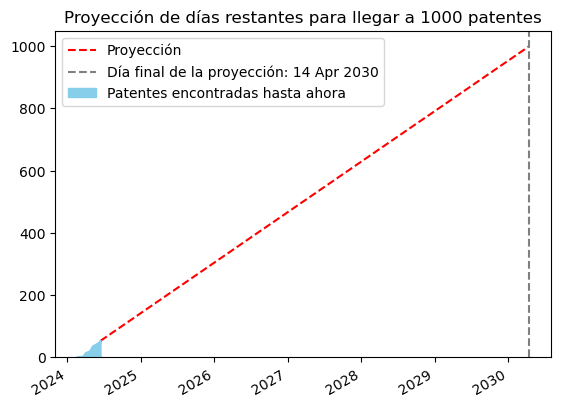

In [26]:
def plot_end_day_proyection(df: pd.DataFrame):
    # Number of days since the first patent was found to the last day of the dataset
    days_since_start = (df["fecha"].max() - df["fecha"].min()).days

    # Number of days to reach 1000 patents
    days_to_1000 = 1000 * days_since_start / len(df)

    # Patentes to reach 1000
    patentes_to_1000 = 1000 - len(df)

    # Create a list with the predicted dates
    days_proyection = []
    day_frequency = days_to_1000 / patentes_to_1000
    for i in range(patentes_to_1000):
        days_proyection.append(
            df["fecha"].max() + pd.DateOffset(days=day_frequency * i)
        )

    patentes_proyection = np.arange(patentes_to_1000) + len(df)

    # Plot the proyection
    plt.plot(
        days_proyection,
        patentes_proyection,
        color="red",
        label="Proyección",
        linestyle="--",
    )

    # Plot line indicating the final date
    plt.axvline(
        days_proyection[-1],
        color="gray",
        linestyle="--",
        label=f"Día final de la proyección: {days_proyection[-1].strftime('%d %b %Y')}",
    )

    # Plot area chart with the number of patents found over time
    found_over_time = df.groupby("fecha").size().cumsum()
    found_over_time.plot(kind="area", color="skyblue", label="Patentes encontradas hasta ahora")

    # Remove the x label
    plt.xlabel("")

    plt.title("Proyección de días restantes para llegar a 1000 patentes")

    plt.legend(
        loc="upper left",
    )

    plt.show()


plot_end_day_proyection(df.copy(deep=True))

### Cuanto pagaría una apuesta de quien encuentra la próxima patente

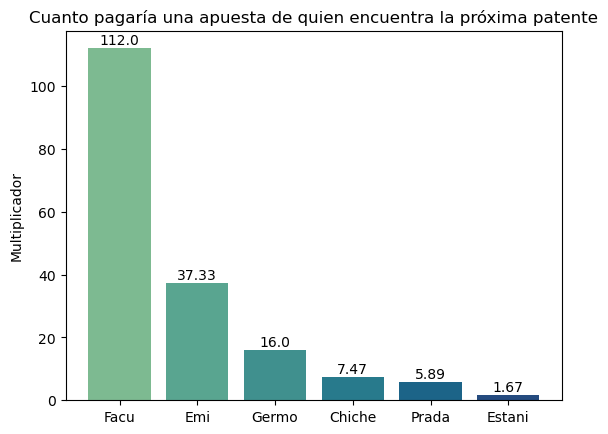

In [21]:
def calculate_odds_of_finding_the_next_patente_for_each_participant(df: pd.DataFrame):
    patentes_found_by_participant = df.groupby("encontradaPor").size()

    if "Facu" not in patentes_found_by_participant.index:
        # Add Facu to the list of people :)
        patentes_found_by_participant["Facu"] = 0

    # We also need to add an Epsilon to avoid having a probability of 0
    epsilon = 0.5

    # Add epsilon to the number of patentes found by each participant
    patentes_found_by_participant += epsilon

    # Calculate the new total of adjusted patentes found
    total_patentes_found = patentes_found_by_participant.sum()

    # Calculate the odds of finding the next patente for each participant
    odds_of_finding_next_patente = patentes_found_by_participant / total_patentes_found

    return odds_of_finding_next_patente

def plot_betting_odds_of_finding_the_next_patente(df: pd.DataFrame):
    odds_of_finding_next_patente = calculate_odds_of_finding_the_next_patente_for_each_participant(df)

    # Calculate the betting odds for each participant
    betting_odds_for_each_participant = 1 / odds_of_finding_next_patente

    # Sort the participants by the odds of finding the next patente
    sorted_participants = betting_odds_for_each_participant.sort_values(ascending=False)

    # Plot the odds of finding the next patente for each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the odds of finding the next patente on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            round(sorted_participants.values[i], 2),
            ha="center",
        )

    plt.ylabel("Multiplicador")

    plt.title("Cuanto pagaría una apuesta de quien encuentra la próxima patente")
    plt.show()

plot_betting_odds_of_finding_the_next_patente(df.copy(deep=True))

### Predicción de distribución para el próximo centésimo

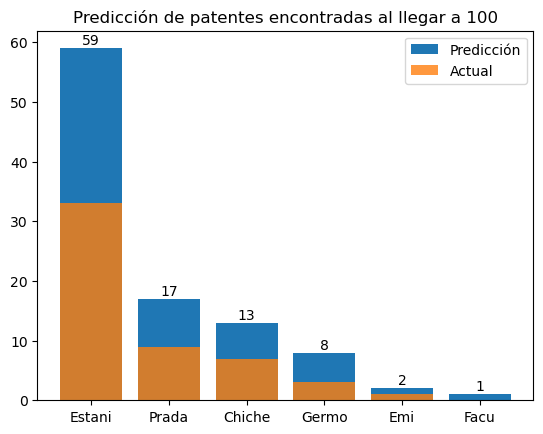

In [208]:
import random

def calculate_odds_of_finding_the_next_patente_for_each_participant(df: pd.DataFrame):
    patentes_found_by_participant = df.groupby("encontradaPor").size()

    if "Facu" not in patentes_found_by_participant.index:
        # Add Facu to the list of people :)
        patentes_found_by_participant["Facu"] = 0

    # We also need to add an Epsilon to avoid having a probability of 0
    epsilon = 0.5

    # Add epsilon to the number of patentes found by each participant
    patentes_found_by_participant += epsilon

    # Calculate the new total of adjusted patentes found
    total_patentes_found = patentes_found_by_participant.sum()

    # Calculate the odds of finding the next patente for each participant
    odds_of_finding_next_patente = (
        patentes_found_by_participant / total_patentes_found
    )

    return odds_of_finding_next_patente


def plot_prediction_distribution_for_next_hundredth(df: pd.DataFrame):
    found_by_participant = df.groupby("encontradaPor").size()

    if "Facu" not in found_by_participant.index:
        # Add Facu to the list of people :)
        found_by_participant["Facu"] = 0

    left_until_next_hundredth = 100 - (len(df) % 100)

    # Calculate the odds of finding the next patente for each participant
    odds_of_finding_next_patente = calculate_odds_of_finding_the_next_patente_for_each_participant(df)

    # Complete the patentes found by each participant to the next hundredth
    found_by_participant_prediction = found_by_participant.copy()
    for _ in range(left_until_next_hundredth):
        participant = random.choices(odds_of_finding_next_patente.index, odds_of_finding_next_patente)[0]
        found_by_participant_prediction[participant] += 1

    # Sort the participants by the number of patentes found
    found_by_participant_prediction = found_by_participant_prediction.sort_values(ascending=False)

    # Plot the distribution of the patentes found by each participant
    plt.bar(
        found_by_participant_prediction.index,
        found_by_participant_prediction
    )

    # Plot the previous number of patentes found by each participant
    plt.bar(
        found_by_participant.index,
        found_by_participant,
        alpha=0.8,
    )

    # Put the number of patents found on top of the bars
    biggest = found_by_participant_prediction.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(found_by_participant_prediction)):
        plt.text(
            i,
            found_by_participant_prediction.values[i] + space_between,
            found_by_participant_prediction.values[i],
            ha="center",
        )

    plt.legend(["Predicción", "Actual"])

    plt.title(f"Predicción de patentes encontradas al llegar a {len(df) + left_until_next_hundredth}")
    plt.show()

plot_prediction_distribution_for_next_hundredth(df.copy(deep=True))

## Correlaciones

Aún sin completar

## Estadisticas por fuera de los datos

### Patentes adulteradas

### Pifies de mandar la patente incorrecta